Segunda parte del modelo: describiremos otra forma distinta de acercarnos a la criticalidad sin la ley de Dale, cogeremos una distribución de autovalores reales e imaginarios que se acercaran a uno con ambas partes distintas de cero. Dada esa distribución haremos los mismo que en la primera parte.

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import math as m
from scipy.stats import linregress

Definimos la funciones que vamos a usar.

In [2]:
def mu_xi_eta(lambda_, xi, eta, alpha, beta, omega):
    term1 = alpha - xi * omega * beta
    sqrt_arg = (1 / lambda_) * (alpha**2 + beta**2) - (beta + xi * omega * alpha)**2
    term2 = eta * np.sqrt(np.maximum(sqrt_arg, 0))
    return (1 / (alpha**2 + beta**2)) * (term1 + term2)

def jacobian_abs(lambda_, xi, alpha, beta, omega):
    arg = (alpha**2 + beta**2) / lambda_ - (alpha * omega + xi * beta)**2
    sqrt_term = np.sqrt(np.maximum(arg, 0))
    with np.errstate(divide='ignore', invalid='ignore'):
        J = np.where(sqrt_term > 0, 1 / (lambda_**2 * sqrt_term), 0)
    return J

def intervalo(alpha, beta, omega, g):
    nu_vals = np.linspace(-2 * g, 2 * g, 1000)
    lambda_minus = sum(1 / ((1 - alpha*nu)**2 + (omega - beta * nu)**2) for nu in nu_vals) / len(nu_vals)
    lambda_plus  = sum(1 / ((1 - alpha*nu)**2 + (omega + beta * nu)**2) for nu in nu_vals) / len(nu_vals)
    return lambda_minus, lambda_plus

def rho_lambda(alpha, beta, omega, k, g):
    lambda_minus, lambda_plus = intervalo(alpha, beta, omega, g)
    lambda_ = np.geomspace(0.23e-1, 2.68e3, 1000)
    total = np.zeros_like(lambda_)

    for xi in [-1, 1]:
        for eta in [-1, 1]:
            mu_val = mu_xi_eta(lambda_, xi, eta, alpha, beta, omega)
            J_abs = jacobian_abs(lambda_, xi, alpha, beta, omega)
            argumento = 4 * g**2 - mu_val**2
            sqrt_term = np.sqrt(np.maximum(argumento, 0))
            total += sqrt_term * J_abs

    return lambda_, (k / 2) * total

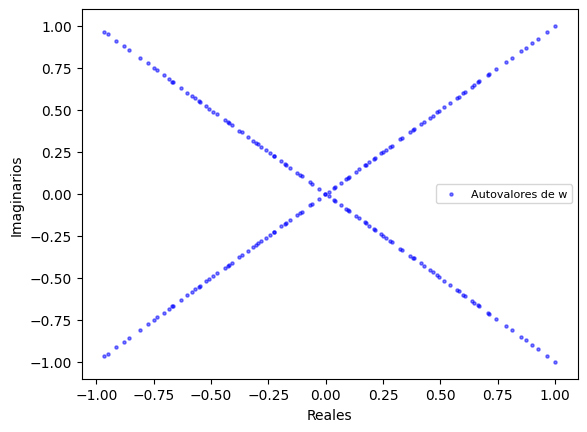

In [5]:
#Lo primero sera definir la matriz J. Matriz aleatoria simetrica de media 0 y varianza N
N=100
J=np.random.normal(0,1/np.sqrt(N),(N,N))
J=0.5*(J+np.transpose(J)) #hacemos la matriz simétrica
alpha=1
beta=1
#A partir de la distribución de J, calculamos la mtriz w que es la que usaremos para calcular los autovalores. Para ello, 
#construimos nuestra matriz de arriba a abajo, definición los hstack (concatena matrices horizontales) y 
# vstack (concatena matrices verticales)

arriba = np.hstack((alpha * J, -beta * J))
abajo = np.hstack((beta * J, alpha * J))
w = np.vstack((arriba, abajo)) 
autovalores= np.linalg.eigvals(w) #calculamos los autovalores de la matriz w
w = w / np.max(np.real(autovalores)) #normalizamos la matriz w para que los autovalores estén en el rango [0,1]
autovalores= np.linalg.eigvals(w)
 
plt.scatter(autovalores.real, autovalores.imag, s=5, color='blue', alpha=0.5, label="Autovalores de w")

plt.xlabel("Reales")
plt.ylabel("Imaginarios")
plt.legend( loc = "center right", fontsize=8)
plt.show()

Calculamos la actividad

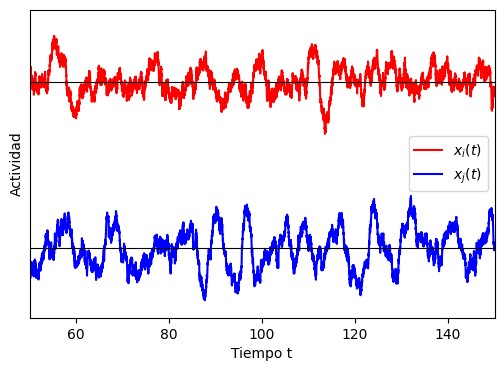

In [6]:
sigma = 1
g = 0.98
T = 200  # Tiempo total
dt = 0.01  # Paso por tiempo
n_iter = int(T / dt)
t = np.linspace(0, T, n_iter)  # Vector de tiempo

# Describimos la matriz A
A = -(np.eye(2*N) - g * w)
# generamos el ruido Gaussinao blanco 
chi = np.random.normal(0, sigma**2, (2*N, n_iter))

# Usamos el método de Euler para calcular la ecuación diferencial (mirar Anexo)
x_t = np.zeros((2*N, n_iter))
for i in range(1, n_iter): #Podemos usar el metodo de euler porque la matriz A tiene autovalores con parte imaginaria menor que uno
    x_t[:, i] = x_t[:, i-1] + np.dot(A, x_t[:, i-1]) * dt + chi[:, i] * np.sqrt(dt)

# Elegimos dos números aleatorios
i, j = (np.random.choice(2*N, 2, replace=False))
#Definimos un offset para que no se superpongan las señales
offset = 10
# Graficamos 
plt.figure(figsize=(6, 4))
#Señal 1
plt.plot(t, x_t[int(i), :].ravel(), color='red', label="$x_i(t)$") #ravel() convierte la matriz en un vector
plt.axhline(0, color="black", linewidth=0.8)  # Linea negra horizontal en 0 para tomarla de referencia
#Señal 2
plt.plot(t, x_t[int(j), :].ravel() - offset, color='blue', label="$x_j(t)$")
plt.axhline(-offset, color="black", linewidth=0.8)  # Linea negra horizontal en 0 para tomarla de referencia
plt.legend(loc='center right', fontsize=10)

plt.xlabel("Tiempo t")
plt.xlim(50,150)
plt.ylabel("Actividad")
plt.yticks([])
plt.show()


Calculamos la distribución de autovalores sabiendo que la frecuencia característica es $w_c=2*\beta*g=0.97$. De esa manera definimos g como $g=\frac{0.97}{\beta*2}$

In [7]:
Nw = 100
w_all=np.geomspace(0.01,100,Nw) #Define el paso de frecuencia en una escala logaritmica
S_w_ii = []
N=100
for w in w_all:
    S_w = np.linalg.inv(A + 1j * w * np.eye(2*N)) @ np.linalg.inv(A.T - 1j * w * np.eye(2*N)) 
    diagonal_S_w = np.diag(S_w)
    S_w_ii.append(diagonal_S_w.mean())
#El código se puede agilizar usando la descomposición de Cholesky o LU.

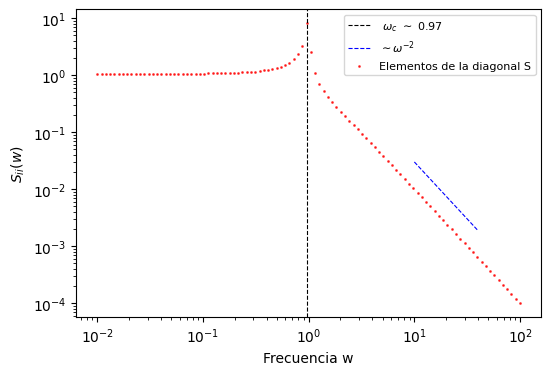

In [ ]:
x=np.linspace(10,40,100)
plt.figure(figsize=(6,4))
#Sacamos el autovalor máximo de S_w_ii y vemos su frecuencia
idx_max = np.argmax(np.real(S_w_ii))
frecuencia_max = w_all[idx_max]

#PLoteamos las frecuencias y la función S_w_ii
plt.axvline(frecuencia_max, color="black", linewidth=0.8, linestyle='--', label=fr" $\omega_c$ $\sim$ 0.97")  # Línea horizontal en max
plt.plot(x,3*x**(-2), 'b--', linewidth=0.8, label=r"$\sim \omega^{-2}$" )  # Línea con pendiente -2 para comparar
plt.scatter(w_all ,np.real(S_w_ii), color='red', s=1, alpha=0.7, label = 'Elementos de la diagonal S')
plt.xlabel('Frecuencia w')
plt.ylabel('$S_{ii}(w)$')
plt.legend(loc = 'upper right', fontsize=8)
plt.yscale('log')
plt.xscale('log')
plt.show()

Hacemos el histograma para los valores $\omega$

In [11]:
#Cálculo de autovalores para diferentes frecuencias
N = 100
alpha = 1
beta = 1
g = 0.97

valores_w = [0, 0.97, 2]
colores_w = ['red', 'green', 'blue']
I = np.eye(2 * N)
autovalores_dict = {w: [] for w in valores_w}

for w, color in zip(valores_w, colores_w):
    for _ in range(100):  # aumenta el número de realizaciones
        J = np.random.normal(0, np.sqrt(1/N), size=(N, N))
        J = 0.5 * (J + J.T)
        arriba = np.hstack((alpha * J, -beta * J))
        abajo = np.hstack((beta * J, alpha * J))
        W = np.vstack((arriba, abajo))
        A = -(np.eye(2*N) - g * W)
        G = A + 1j * w * I
        S_w = np.linalg.inv(G) @ np.linalg.inv(G.conj().T)
        autovalores = np.linalg.eigvalsh(S_w)
        autovalores_dict[w].extend(np.abs(autovalores))

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
C:\Users\carlo\AppData\Local\Temp\ipykernel_12484\1396660142.py:17: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(valores_lambda[mask], p_valores[mask], '-', color=color, alpha=0.6, label = f"$\omega = {w}$")


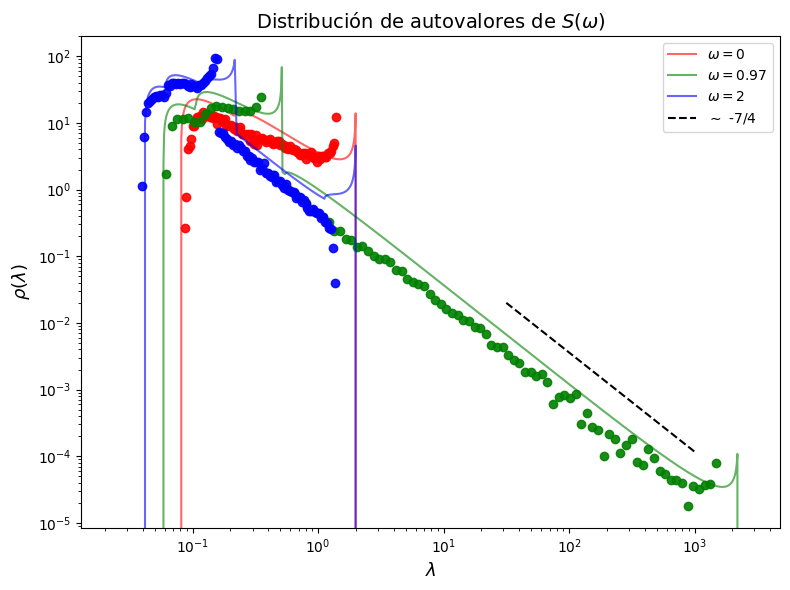

In [29]:
# Ploteo teórico de la distribución de autovalores
k = 1
plt.figure(figsize=(8, 6))

for w,color in zip(valores_w, colores_w):
    autovalores_array = np.array(autovalores_dict[w])
    valores_lambda, p_valores = rho_lambda(alpha, beta, w, k, g)

    min_val = np.min(autovalores_array[autovalores_array > 0])
    max_val = np.max(autovalores_array)
    bins_log = np.logspace(np.log10(min_val), np.log10(max_val), 100)
    counts, bins = np.histogram(autovalores_array, bins=bins_log, density=True)
    bin_centers = np.sqrt(bins[:-1] * bins[1:])

    plt.plot( 0.70* bin_centers,  3 * np.pi * counts, 'o', color=color, alpha=0.9)
    mask = p_valores < 100  # evita los picos extremos
    plt.plot(valores_lambda[mask], p_valores[mask], '-', color=color, alpha=0.6, label = f"$\omega = {w}$")
    

x_line = np.logspace(1.5, 3, 100)
# Ajuste lineal en escala log-log para la curva verde (w = valores_w[1])
mask_green = (valores_lambda > 10) & (valores_lambda < 100)
log_x = np.log10(valores_lambda[mask_green])
log_y = np.log10(rho_lambda(alpha, beta, valores_w[1], k, g)[1][mask_green])
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
plt.plot(x_line, 3*10**intercept * x_line**slope, color = 'black',  linestyle = '--', label = fr"$\sim$ -7/4")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$\\lambda$", fontsize=13)
plt.ylabel("$\\rho(\\lambda)$", fontsize=13)
plt.title("Distribución de autovalores de $S(\\omega)$", fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

Código de Rubén:

The spectra is bounded in [ 0.21518333620244448 2.0 ]
The spectra is bounded in [ 0.1349218128094769 222.2222222222218 ]
The spectra is bounded in [ 0.08059836224127925 0.8871540099361247 ]


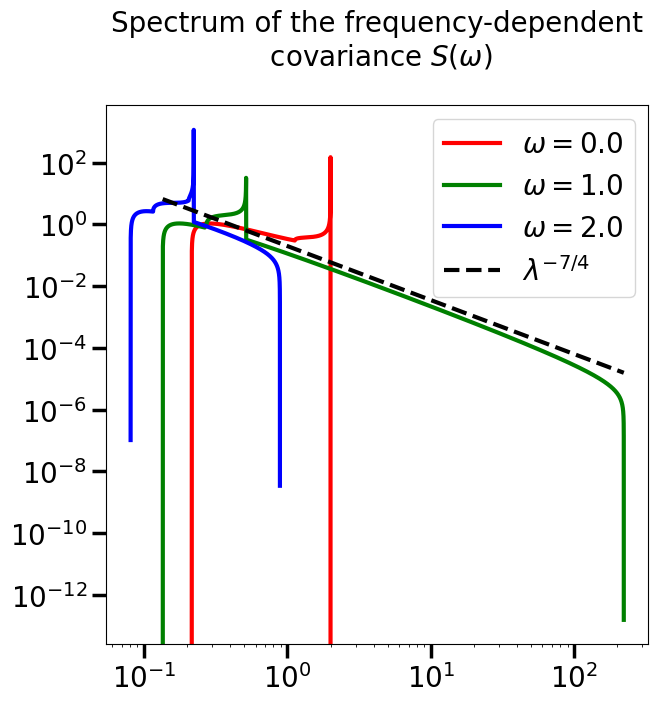

In [ ]:
def theoretical(alpha, beta, w, g, Npoints):
   
    #Gives the theoretical distribution of eigenvalues for parameters:
    #alpha, beta, w (omega), g, drawn in Npoints different.
   
    lambdamin, lambdamax = Extremos(alpha, beta, w, g)
    print('The spectra is bounded in [', lambdamin, lambdamax, ']')
    lambdas=np.linspace(lambdamin, lambdamax, Npoints)
    D=alpha**2+beta**2
    C=1/(8*np.pi*g**2)
    rho=np.zeros(Npoints)
   
    for i in range(Npoints):
        for j in range(-1,2,2):   # xi
            #Calculate the discriminant Delta(Lambda):
            discr=(1/lambdas[i])*D-(j*beta+w*alpha)**2
            #Calculate the maximum mu*:
            mustar=(alpha-j*w*beta)/D
           
            #Now, calculate the final discriminant for each value of eta(k):
            for k in range(-1,2,2):
                if (discr>0): # eta
                    newdiscr=(4*g**2-mustar**2)/discr-(1/D)*(2*mustar*k/np.sqrt(discr)+1/D)
                    if (newdiscr>0):
                        rho[i]+=np.sqrt(newdiscr)/lambdas[i]**2
   
    return lambdas, C*rho

def Extremos(alpha, beta, w, g):
   
    lambdamax=0
    lambdamin=10**6
   
    for xi in range(-1,2,2):
        condicion1=(alpha-xi*w*beta)/(alpha**2+beta**2) >  2*g
        condicion2=(alpha-xi*w*beta)/(alpha**2+beta**2) < -2*g

        if (condicion1): #Case (i)  
            lambdamax_PROV = 1/((1-2*alpha*g)**2+(w+xi*2*beta*g)**2)
            lambdamin_PROV = 1/((1+2*alpha*g)**2+(w-xi*2*beta*g)**2)
        elif (condicion2): #Case (ii)
            lambdamax_PROV = 1/((1+2*alpha*g)**2+(w-xi*2*beta*g)**2)
            lambdamin_PROV = 1/((1-2*alpha*g)**2+(w+xi*2*beta*g)**2)
        else:
            lambdamax_PROV  = (alpha**2+beta**2)/(beta+xi*w*alpha)**2
            lambdamin_PROV1 = 1/((1-2*alpha*g)**2+(w+xi*2*beta*g)**2)
            lambdamin_PROV2 = 1/((1+2*alpha*g)**2+(w-xi*2*beta*g)**2)
           
            if (lambdamin_PROV1<lambdamin_PROV2):
                lambdamin_PROV=lambdamin_PROV1
            else:
                lambdamin_PROV=lambdamin_PROV2


        if (lambdamax_PROV>lambdamax):
            lambdamax = lambdamax_PROV
        if (lambdamin_PROV<lambdamin):
            lambdamin = lambdamin_PROV
           
       
    return lambdamin, lambdamax  

fig, axs = plt.subplots(1, figsize=(7,7))
F=np.array([0, 0.97, 2.0])
alpha=1
beta=-1
g=0.47
Npoints=10**5
lambdas=np.zeros((len(F),Npoints))
rho=np.zeros(np.shape(lambdas))
c=['r', 'g', 'b']

for i in range(len(F)):
    lambdas[i,:], rho[i,:] = theoretical(alpha, beta, F[i], g, Npoints)
    axs.plot(lambdas[i,:], rho[i,:], color=c[i], lw=3, label='$\\omega=$%1.1f' %F[i])

axs.plot(lambdas[1,:], 0.2*lambdas[1,:]**(-7/4), '--k', lw=3, label='$\\lambda^{-7/4}$')
axs.legend(fontsize=20)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_title('Spectrum of the frequency-dependent\n covariance $S(\\omega)$\n', fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)

In [28]:
def circle_law(N, R):
    #Circle law, N-> Number of results
    # R-> Radius of the semicircle-law
   
    U=np.zeros(N)
    Ns=0
   
    while(Ns<N):
        x=R*(2*np.random.rand()-1)
        y=R*(np.random.rand())
        if (y<np.sqrt(R**2-x**2)):
            U[Ns]=x
            Ns+=1
    return U

N=10**2
J=1
J0=0

#Connectivity parameters:
g=0.49
a=1
b=-1
#-----------------------

M=10**2
W=np.zeros((2*N, 2*N))

eigens0=np.zeros((2*N,M))
eigens1=np.zeros((2*N,M))
eigens2=np.zeros((2*N,M))

for m in range(M):
   
    eigs=circle_law(N, 2*g)
   
    omega0=0
    eigens0[:N,m]=1/((1-a*eigs)**2+(omega0+b*eigs)**2)
    eigens0[N:,m]=1/((1-a*eigs)**2+(omega0-b*eigs)**2)
   
    omega1=0.97
    eigens1[:N,m]=1/((1-a*eigs)**2+(omega1+b*eigs)**2)
    eigens1[N:,m]=1/((1-a*eigs)**2+(omega1-b*eigs)**2)
   
    omega2=2.0
    eigens2[:N,m]=1/((1-a*eigs)**2+(omega2+b*eigs)**2)
    eigens2[N:,m]=1/((1-a*eigs)**2+(omega2-b*eigs)**2)




<>:30: SyntaxWarning: invalid escape sequence '\l'
<>:31: SyntaxWarning: invalid escape sequence '\l'
<>:30: SyntaxWarning: invalid escape sequence '\l'
<>:31: SyntaxWarning: invalid escape sequence '\l'
C:\Users\carlo\AppData\Local\Temp\ipykernel_2180\1269073990.py:30: SyntaxWarning: invalid escape sequence '\l'
  axs.set_xlabel('$\lambda$', fontsize=18)
C:\Users\carlo\AppData\Local\Temp\ipykernel_2180\1269073990.py:31: SyntaxWarning: invalid escape sequence '\l'
  axs.set_ylabel('$\\rho(\lambda)$', fontsize=18)


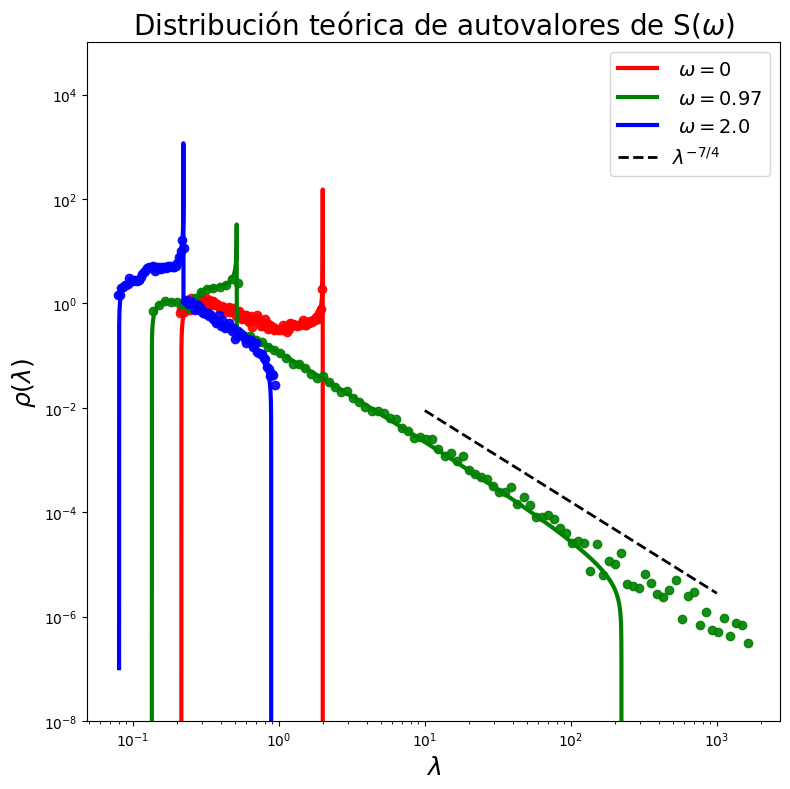

In [35]:
# PLOT COMPARATIVO TEORÍA VS SIMULACIÓN

import matplotlib.pyplot as plt

# Asumimos que lambdas[0], rho[0] son la teoría para omega=0, etc.
omegas = [0, 0.97, 2.0]
eigens = [eigens0, eigens1, eigens2]
colors = ['r', 'g', 'b']

fig, axs = plt.subplots(1, 1, figsize=(8, 8))

for i in range(3):
    min_val1 = np.min(eigens[i])
    max_val1 = np.max(eigens[i])
    
    # Teórico
    bins_log1 = np.logspace(np.log10(min_val1), np.log10(max_val1), 100)
    counts1, bins1 = np.histogram(eigens[i].flatten(), bins=bins_log1, density=True)
    bin_centers1 = np.sqrt(bins1[:-1] * bins1[1:])
    plt.plot( bin_centers1, counts1, 'o', color=colors[i], alpha=0.9)
    axs.plot(lambdas[i], rho[i], color=colors[i], lw=3, label=f" $\\omega={omegas[i]}$")


    # Línea de referencia de pendiente -7/4
x_ref = np.logspace(1, 3, 100)
axs.plot(x_ref, 0.5 * x_ref**(-7/4), '--k', lw=2, label='$\\lambda^{-7/4}$')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_ylim(1e-8, 100000)
axs.set_xlabel('$\lambda$', fontsize=18)
axs.set_ylabel('$\\rho(\lambda)$', fontsize=18)
axs.set_title('Distribución teórica de autovalores de S($\\omega$)', fontsize=20)
axs.legend(fontsize=14)

plt.tight_layout()
plt.show()


<>:44: SyntaxWarning: invalid escape sequence '\l'
<>:45: SyntaxWarning: invalid escape sequence '\l'
<>:44: SyntaxWarning: invalid escape sequence '\l'
<>:45: SyntaxWarning: invalid escape sequence '\l'
C:\Users\carlo\AppData\Local\Temp\ipykernel_2180\3757457491.py:44: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=16)
C:\Users\carlo\AppData\Local\Temp\ipykernel_2180\3757457491.py:45: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\\rho(\lambda)$', fontsize=16)


The spectra is bounded in [ 0.20488444517292248 2.0 ]


ω = 0.0: 100%|██████████| 1000/1000 [00:08<00:00, 113.52it/s]


The spectra is bounded in [ 0.12948503800385866 1999.9999999999966 ]


ω = 0.97: 100%|██████████| 1000/1000 [00:08<00:00, 118.17it/s]


The spectra is bounded in [ 0.07812011749265671 0.9607993850883936 ]


ω = 2.0: 100%|██████████| 1000/1000 [00:08<00:00, 117.25it/s]


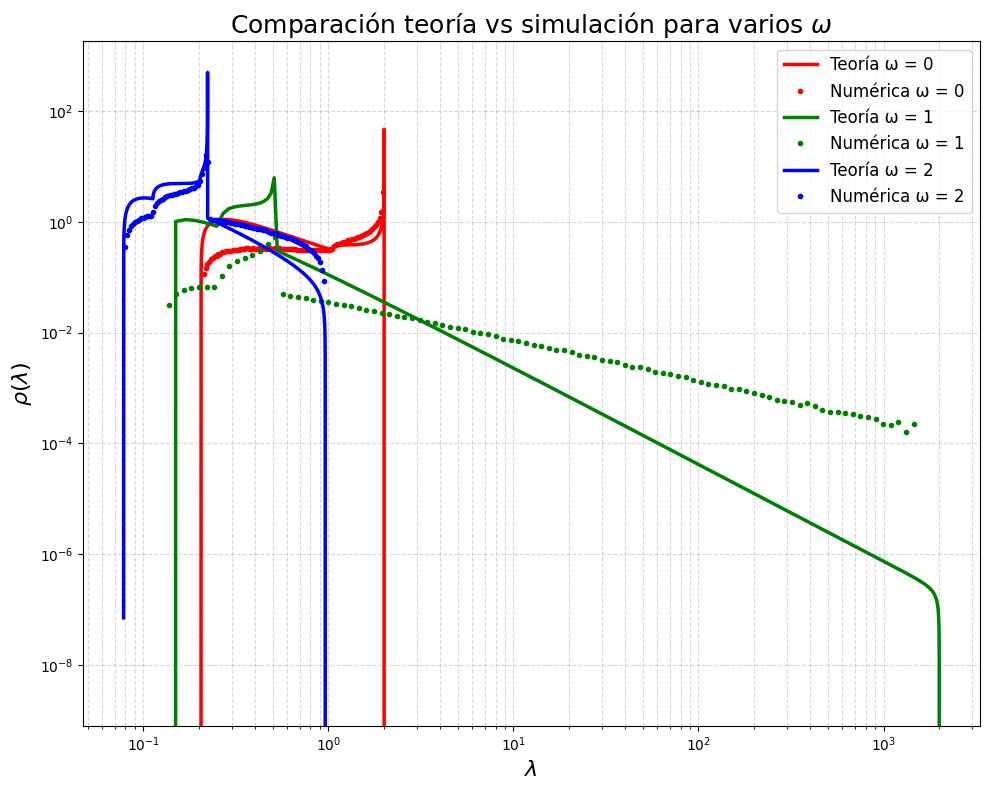

In [17]:
from tqdm import tqdm
# Repetimos para omega = 0, 1, 2 pero sin almacenar todos los autovalores
plt.figure(figsize=(10, 8))
omegas = [0.0, 0.97, 2.0]
colors = ['r', 'g', 'b']
labels = ['ω = 0', 'ω = 1', 'ω = 2']
N_hist = 100  # número de bins para histograma

for idx, omega in enumerate(omegas):
    # Teoría
    lambdas_theory, rho_theory = theoretical(alpha, beta, omega, g, Npoints)

    # Estimar extremos de histograma con algunas muestras
    eigs_sample = circle_law(N, 2 * g)
    sample_vals = np.concatenate([
        1 / ((1 - alpha * eigs_sample)**2 + (omega + beta * eigs_sample)**2),
        1 / ((1 - alpha * eigs_sample)**2 + (omega - beta * eigs_sample)**2)
    ])
    min_val = np.min(sample_vals[sample_vals > 0])
    max_val = np.max(sample_vals)
    bins_log = np.logspace(np.log10(min_val), np.log10(max_val), N_hist)
    counts = np.zeros(N_hist - 1)

    # Acumular histograma sin guardar todos los datos
    for m in tqdm(range(M), desc=f"ω = {omega}"):
        eigs = circle_law(N, 2 * g)
        eig_omega_plus = 1 / ((1 - alpha * eigs)**2 + (omega + beta * eigs)**2)
        eig_omega_minus = 1 / ((1 - alpha * eigs)**2 + (omega - beta * eigs)**2)
        data = np.concatenate([eig_omega_plus, eig_omega_minus])
        c, _ = np.histogram(data, bins=bins_log)
        counts += c

    # Normalizar el histograma
    bin_widths = np.diff(bins_log)
    counts = counts / (np.sum(counts * bin_widths))  # densidad normalizada
    bin_centers = np.sqrt(bins_log[:-1] * bins_log[1:])

    # Plot
    plt.plot(lambdas_theory, rho_theory, color=colors[idx], lw=2.5, label=f'Teoría {labels[idx]}')
    plt.plot(bin_centers, counts, 'o', color=colors[idx], markersize=3, label=f'Numérica {labels[idx]}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$', fontsize=16)
plt.ylabel('$\\rho(\lambda)$', fontsize=16)
plt.title('Comparación teoría vs simulación para varios $\\omega$', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
